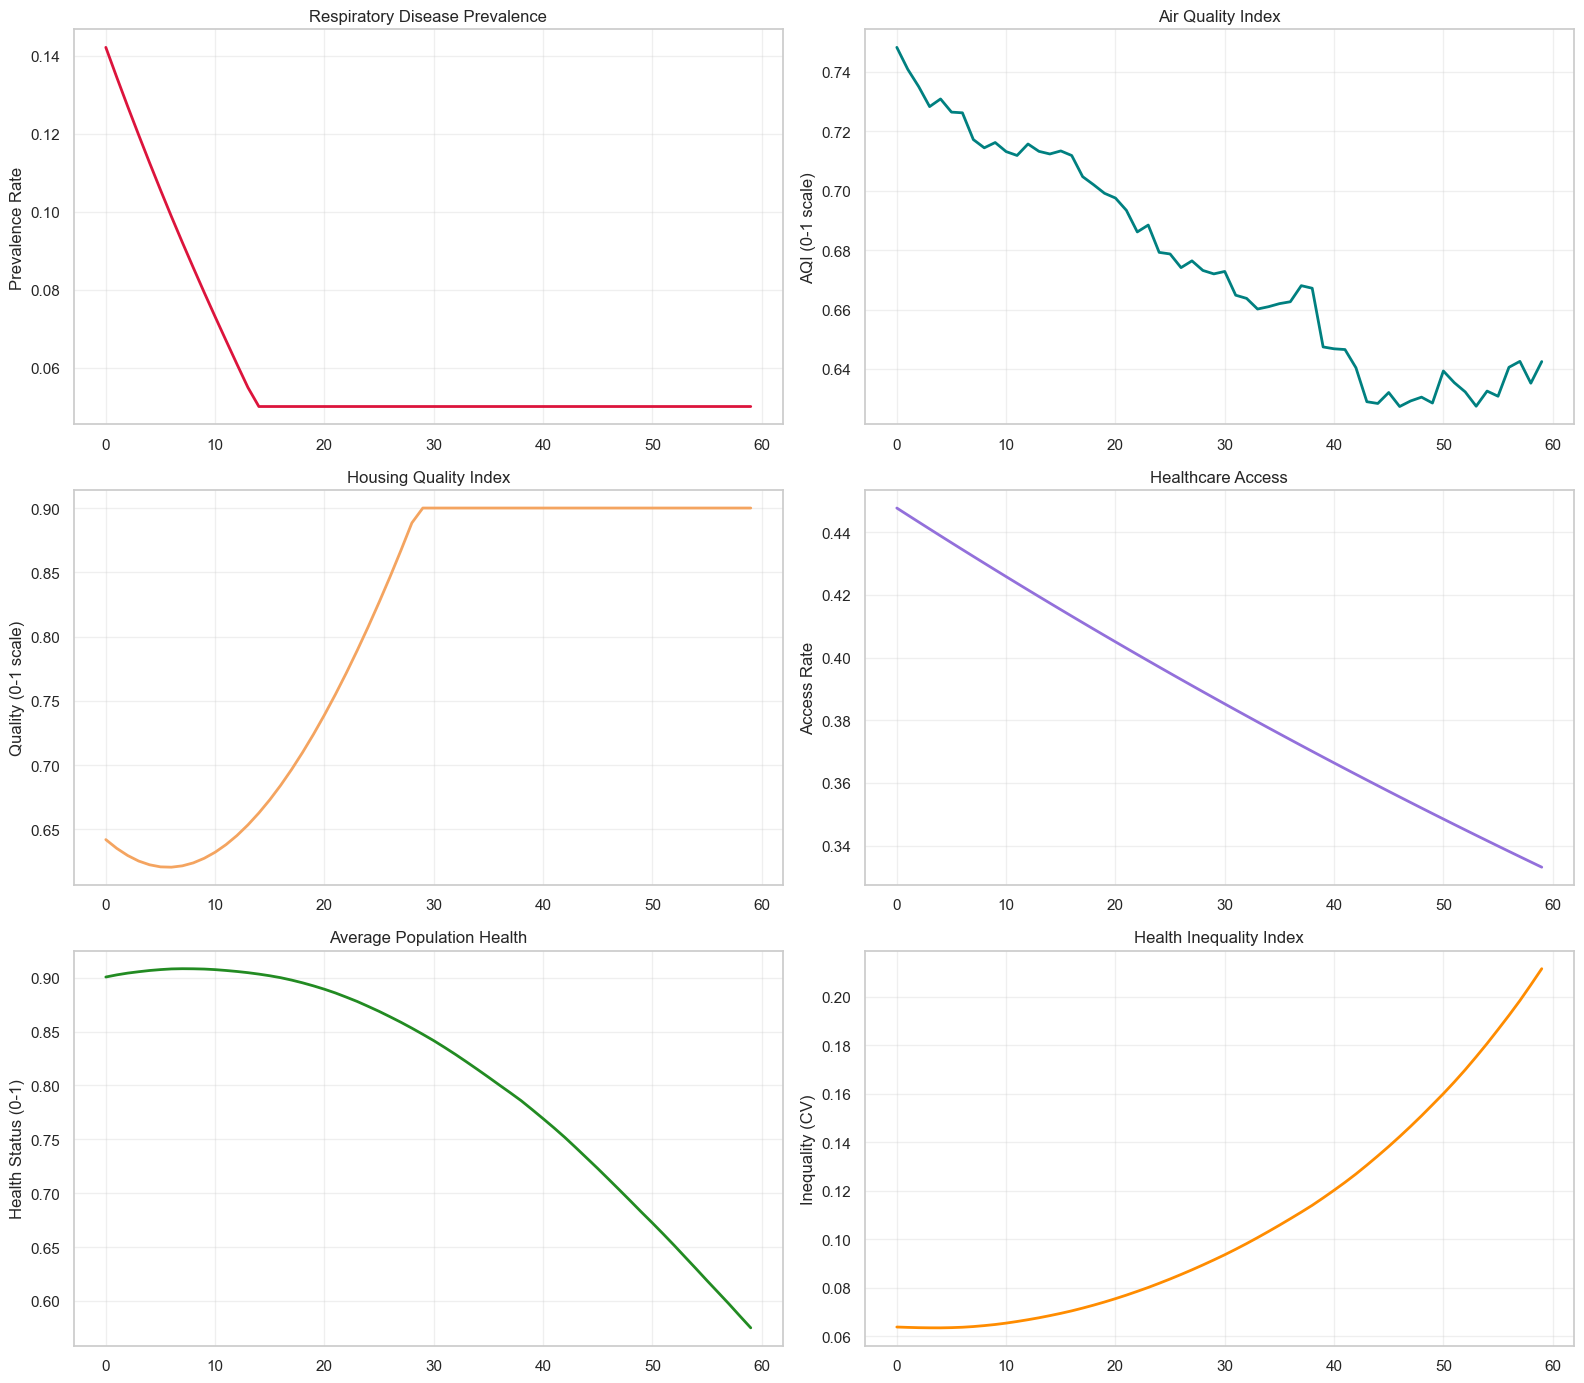

C:\Users\fardo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\fardo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


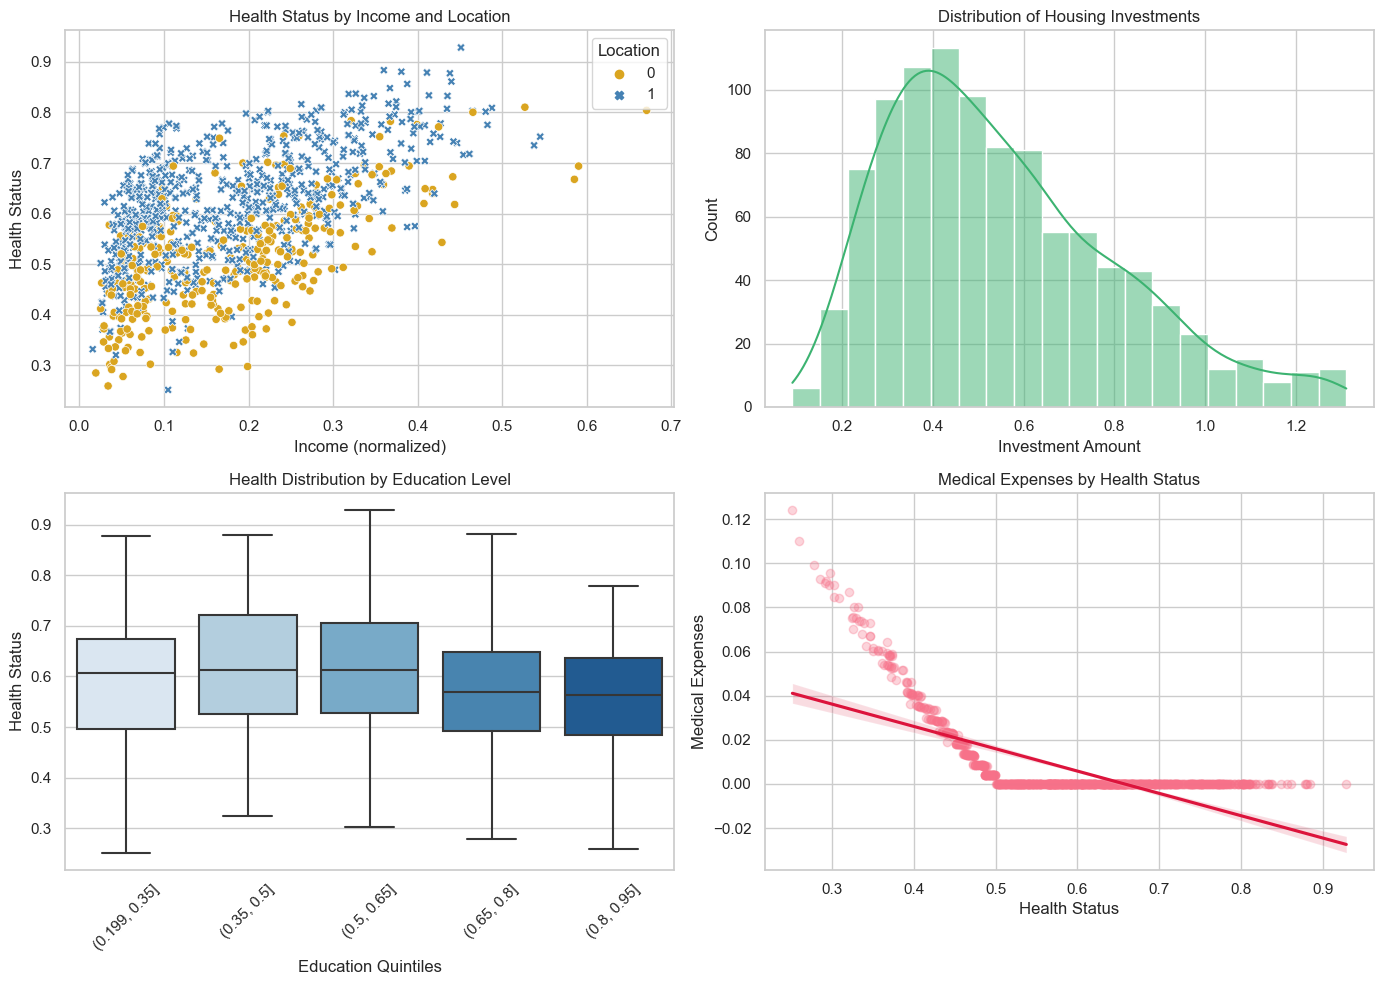


=== SIMULATION SUMMARY ===
Final Average Health: 0.575
Health Inequality (CV): 0.212
Disease Prevalence: 0.050
Healthcare Access: 0.333

Correlation Matrix:
              Health    Income  Education  Investment
Health      1.000000  0.548199  -0.144852    0.172147
Income      0.548199  1.000000  -0.766556   -0.463822
Education  -0.144852 -0.766556   1.000000    0.726120
Investment  0.172147 -0.463822   0.726120    1.000000


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from scipy.stats import skewnorm

import seaborn as sns
sns.set_theme(style="whitegrid", palette="husl")



# -------------------------------
# ENHANCED SYSTEM DYNAMICS COMPONENT
# -------------------------------
class HealthSDModel:
    def __init__(self):
        # Initialize with more realistic baseline values
        self.housing_quality = 0.65  # 0-1 scale (1 = best)
        self.air_quality_index = 0.75  # 0-1 scale (1 = best)
        self.disease_prevalence = 0.15  # 0-1 scale (0 = none)
        
        # Realistic parameters with units
        self.climate_change_rate = 0.015  # annual deterioration rate
        self.healthcare_access = 0.45  # coverage percentage
        self.base_housing_deterioration = 0.008  # annual without maintenance
        self.housing_improvement_factor = 0.08  # effectiveness of investments
        
        # Additional realistic factors
        self.extreme_weather_frequency = 0.05  # probability per year
        self.public_health_budget = 1000000  # in local currency
        
        # Historical tracking
        self.history = {
            'housing_quality': [self.housing_quality],
            'air_quality_index': [self.air_quality_index],
            'disease_prevalence': [self.disease_prevalence],
            'healthcare_access': [self.healthcare_access]
        }

    def step(self, avg_investment=0, extreme_weather=False):
        """Update SD model with more realistic relationships"""
        
        # Climate impact increases with poor housing and extreme weather
        climate_impact = (self.climate_change_rate * (1 - self.housing_quality) * 
                         (3 if extreme_weather else 1))
        
        # Air quality affected by housing, climate, and random fluctuations
        air_quality_change = (
            -0.012 * (1 - self.housing_quality) 
            - climate_impact * 0.04 
            + np.random.normal(0, 0.005)  # random variation
        )
        self.air_quality_index += air_quality_change
        self.air_quality_index = np.clip(self.air_quality_index, 0.3, 0.95)  # realistic bounds
        
        # Disease dynamics with seasonal variation
        seasonal_factor = 0.5 + 0.5 * np.sin(len(self.history['disease_prevalence']) * 0.1)
        new_cases = (
            (1 - self.air_quality_index) * 
            (1 - self.healthcare_access) * 
            0.015 * seasonal_factor
        )
        recovery_rate = 0.02 * self.healthcare_access
        self.disease_prevalence += new_cases - recovery_rate
        self.disease_prevalence = np.clip(self.disease_prevalence, 0.05, 0.8)  # realistic bounds
        
        # Housing quality dynamics
        maintenance_effect = avg_investment * self.housing_improvement_factor
        deterioration = self.base_housing_deterioration * (1 + climate_impact)
        self.housing_quality += maintenance_effect - deterioration
        self.housing_quality = np.clip(self.housing_quality, 0.2, 0.9)  # realistic bounds
        
        # Healthcare system adjustments
        if self.disease_prevalence > 0.3:
            self.healthcare_access += min(0.02, self.public_health_budget/10000000)
        else:
            self.healthcare_access *= 0.995  # gradual decline without pressure
        
        # Store history
        for var in ['housing_quality', 'air_quality_index', 'disease_prevalence', 'healthcare_access']:
            self.history[var].append(getattr(self, var))

        return {
            'housing_quality': self.housing_quality,
            'air_quality_index': self.air_quality_index,
            'disease_prevalence': self.disease_prevalence,
            'healthcare_access': self.healthcare_access
        }

# -------------------------------
# ENHANCED AGENT-BASED COMPONENT
# -------------------------------
class Household(Agent):
    def __init__(self, unique_id, model, income_level, education_level, location_type):
        super().__init__(unique_id, model)
        # Realistic attribute distributions
        self.income = income_level  # in local currency units
        self.education = education_level  # years of education (0-20 normalized to 0-1)
        self.location = location_type  # 0=rural, 1=urban
        self.health_status = 0.8 + 0.2 * np.random.random()  # initial health
        self.housing_investment = 0
        self.medical_expenses = 0
        self.risk_perception = np.random.beta(2, 5)  # initially low risk perception
        
        # Household-specific factors
        self.family_size = np.random.poisson(3.5) + 1
        self.age = np.random.randint(20, 80)  # head of household age
        
    def step(self):
        sd = self.model.sd_model
        env_risk = 1 - sd.air_quality_index
        
        # Update risk perception based on environment and information
        self.risk_perception = min(0.9, 
            self.risk_perception * 0.9 + 
            env_risk * 0.1 + 
            (0.1 if self.education > 0.7 else 0)
        )        
        # Investment decision making
        investment_prob = (
            0.1 * self.income + 
            0.3 * self.risk_perception + 
            0.2 * self.education
        )
        if np.random.random() < investment_prob:
            invest_amount = min(
                0.05 * self.income * (1 + self.education),
                self.income * 0.15  # don't spend more than 15% of income
            )
            self.housing_investment += invest_amount
            self.income -= invest_amount * 0.9  # some money leaves local economy
        
        # Health dynamics
        vulnerability = (
            0.3 * (1 - self.income) + 
            0.2 * (1 - self.education) + 
            0.1 * (self.age/80) + 
            0.4 * (1 if self.location == 0 else 0.7)  # rural more vulnerable
        )
        health_change = (
            -env_risk * vulnerability * 0.08 * (1 - sd.healthcare_access) +
            (0.02 * sd.healthcare_access * min(1, self.income/0.5))  # recovery
        )
        self.health_status += health_change
        self.health_status = np.clip(self.health_status, 0.1, 1.0)
        
        # Economic dynamics
        if self.health_status < 0.5:
            self.income *= 0.98  # lost productivity
            self.medical_expenses += 0.02 * (0.7 - self.health_status)
        
        # Periodic income changes
        if self.model.schedule.time % 12 == 0:  # yearly adjustment
            self.income *= 1 + np.random.normal(0.02, 0.01)  # small growth or fluctuation

# -------------------------------
# ENHANCED HYBRID MODEL (CORRECTED)
# -------------------------------
class HybridModel(Model):
    def __init__(self, N_households=500):
        super().__init__()
        self.sd_model = HealthSDModel()
        self.schedule = RandomActivation(self)
        self.time = 0  # track months
        
        # Enhanced data collection - now using lambda functions to properly bind methods
        self.datacollector = DataCollector(
            model_reporters={
                "Avg_Health": lambda m: m.calculate_avg_health(),
                "Health_Inequality": lambda m: m.calculate_health_inequality(),
                "Housing_Quality": lambda m: m.sd_model.housing_quality,
                "Air_Quality_Index": lambda m: m.sd_model.air_quality_index,
                "Disease_Prevalence": lambda m: m.sd_model.disease_prevalence,
                "Healthcare_Access": lambda m: m.sd_model.healthcare_access,
                "Extreme_Weather": lambda m: getattr(m, 'extreme_weather_event', False)
            },
            agent_reporters={
                "Health": "health_status",
                "Income": "income",
                "Education": "education",
                "Location": "location",
                "Investment": "housing_investment",
                "Medical_Expenses": "medical_expenses"
            }
        )
        
        # Create realistic population distribution
        for i in range(N_households):
            # Skewed income distribution
            income = np.clip(skewnorm.rvs(5, loc=0.4, scale=0.3), 0.1, 1.2)
            
            # Safely compute beta parameters
            a_param = 1 + income * 3
            b_param = max(0.5, 3 - income * 2)  # Ensure b > 0
        
            # Education correlated with income
            education = np.clip(np.random.beta(a_param, b_param), 0.2, 0.95)
            
            # Location - 70% urban
            location = 1 if np.random.random() < 0.7 else 0
            agent = Household(i, self, income, education, location)
            self.schedule.add(agent)

    def calculate_avg_health(self):
        """Calculate average health of all agents"""
        return np.mean([a.health_status for a in self.schedule.agents])
    
    def calculate_health_inequality(self):
        """Calculate health inequality (coefficient of variation)"""
        health = [a.health_status for a in self.schedule.agents]
        return np.std(health) / np.mean(health) if np.mean(health) > 0 else 0
    
    def step(self):
        self.time += 1
        
        # Determine if extreme weather occurs this period (5% annual chance)
        extreme_weather = False
        if np.random.random() < (0.05/12):  # monthly probability
            extreme_weather = True
            self.extreme_weather_event = True
        else:
            self.extreme_weather_event = False
        
        # Calculate average community investment
        avg_investment = np.mean([
            a.housing_investment for a in self.schedule.agents
        ]) if len(self.schedule.agents) > 0 else 0
        
        # Update SD model
        self.sd_model.step(avg_investment=avg_investment, extreme_weather=extreme_weather)
        
        # Update all agents
        self.schedule.step()
        
        # Collect data
        self.datacollector.collect(self)

# -------------------------------
# REALISTIC VISUALIZATION FUNCTIONS
# -------------------------------
def plot_simulation_results(results):
    """Create publication-quality visualizations of results"""
    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    
    # Time series plots
    results['Disease_Prevalence'].plot(ax=axes[0,0], color='crimson', linewidth=2)
    axes[0,0].set_title('Respiratory Disease Prevalence', fontsize=12)
    axes[0,0].set_ylabel('Prevalence Rate')
    axes[0,0].grid(True, alpha=0.3)
    
    results['Air_Quality_Index'].plot(ax=axes[0,1], color='teal', linewidth=2)
    axes[0,1].set_title('Air Quality Index', fontsize=12)
    axes[0,1].set_ylabel('AQI (0-1 scale)')
    axes[0,1].grid(True, alpha=0.3)
    
    results['Housing_Quality'].plot(ax=axes[1,0], color='sandybrown', linewidth=2)
    axes[1,0].set_title('Housing Quality Index', fontsize=12)
    axes[1,0].set_ylabel('Quality (0-1 scale)')
    axes[1,0].grid(True, alpha=0.3)
    
    results['Healthcare_Access'].plot(ax=axes[1,1], color='mediumpurple', linewidth=2)
    axes[1,1].set_title('Healthcare Access', fontsize=12)
    axes[1,1].set_ylabel('Access Rate')
    axes[1,1].grid(True, alpha=0.3)
    
    results['Avg_Health'].plot(ax=axes[2,0], color='forestgreen', linewidth=2)
    axes[2,0].set_title('Average Population Health', fontsize=12)
    axes[2,0].set_ylabel('Health Status (0-1)')
    axes[2,0].grid(True, alpha=0.3)
    
    results['Health_Inequality'].plot(ax=axes[2,1], color='darkorange', linewidth=2)
    axes[2,1].set_title('Health Inequality Index', fontsize=12)
    axes[2,1].set_ylabel('Inequality (CV)')
    axes[2,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_agent_distributions(agent_data):
    """Visualize distributions of agent characteristics"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Health vs Income
    sns.scatterplot(
        x='Income', y='Health', 
        hue='Location', 
        style='Location',
        palette={0: 'goldenrod', 1: 'steelblue'},
        data=agent_data, 
        ax=axes[0,0]
    )
    axes[0,0].set_title('Health Status by Income and Location')
    axes[0,0].set_xlabel('Income (normalized)')
    axes[0,0].set_ylabel('Health Status')
    
    # Investment distribution
    sns.histplot(
        agent_data['Investment'], 
        bins=20, 
        kde=True,
        color='mediumseagreen',
        ax=axes[0,1]
    )
    axes[0,1].set_title('Distribution of Housing Investments')
    axes[0,1].set_xlabel('Investment Amount')
    
    # Health inequality by education
    sns.boxplot(
        x=pd.cut(agent_data['Education'], bins=5),
        y='Health',
        data=agent_data,
        palette='Blues',
        ax=axes[1,0]
    )
    axes[1,0].set_title('Health Distribution by Education Level')
    axes[1,0].set_xlabel('Education Quintiles')
    axes[1,0].set_ylabel('Health Status')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # Medical expenses by health status
    sns.regplot(
        x='Health', y='Medical_Expenses',
        data=agent_data,
        scatter_kws={'alpha':0.3},
        line_kws={'color':'crimson'},
        ax=axes[1,1]
    )
    axes[1,1].set_title('Medical Expenses by Health Status')
    axes[1,1].set_xlabel('Health Status')
    axes[1,1].set_ylabel('Medical Expenses')
    
    plt.tight_layout()
    plt.show()

# -------------------------------
# RUN ENHANCED SIMULATION
# -------------------------------
def run_enhanced_simulation(years=10):
    """Run simulation with realistic parameters"""
    months = years * 12
    model = HybridModel(N_households=1000)
    
    for _ in range(months):
        model.step()
    
    model_results = model.datacollector.get_model_vars_dataframe()
    agent_results = model.datacollector.get_agent_vars_dataframe()
    
    return model, model_results, agent_results

# Execute simulation
model, model_results, agent_data = run_enhanced_simulation(years=5)

# Visualize results
plot_simulation_results(model_results)

# Analyze final time step
final_agents = agent_data.xs(model.schedule.time-1, level='Step')
plot_agent_distributions(final_agents)

# Print key statistics
print("\n=== SIMULATION SUMMARY ===")
print(f"Final Average Health: {model_results['Avg_Health'].iloc[-1]:.3f}")
print(f"Health Inequality (CV): {model_results['Health_Inequality'].iloc[-1]:.3f}")
print(f"Disease Prevalence: {model_results['Disease_Prevalence'].iloc[-1]:.3f}")
print(f"Healthcare Access: {model_results['Healthcare_Access'].iloc[-1]:.3f}")

# Calculate correlations
corr_matrix = final_agents[['Health', 'Income', 'Education', 'Investment']].corr()
print("\nCorrelation Matrix:")
print(corr_matrix)

Running scenario: Urban Baseline
Running scenario: Urban Climate Stress
Running scenario: Urban Climate + Policy
Extreme weather event at step 3
Running scenario: Rural Baseline
Extreme weather event at step 89
Running scenario: Rural Climate Stress


C:\Users\fardo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\fardo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\fardo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\fardo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

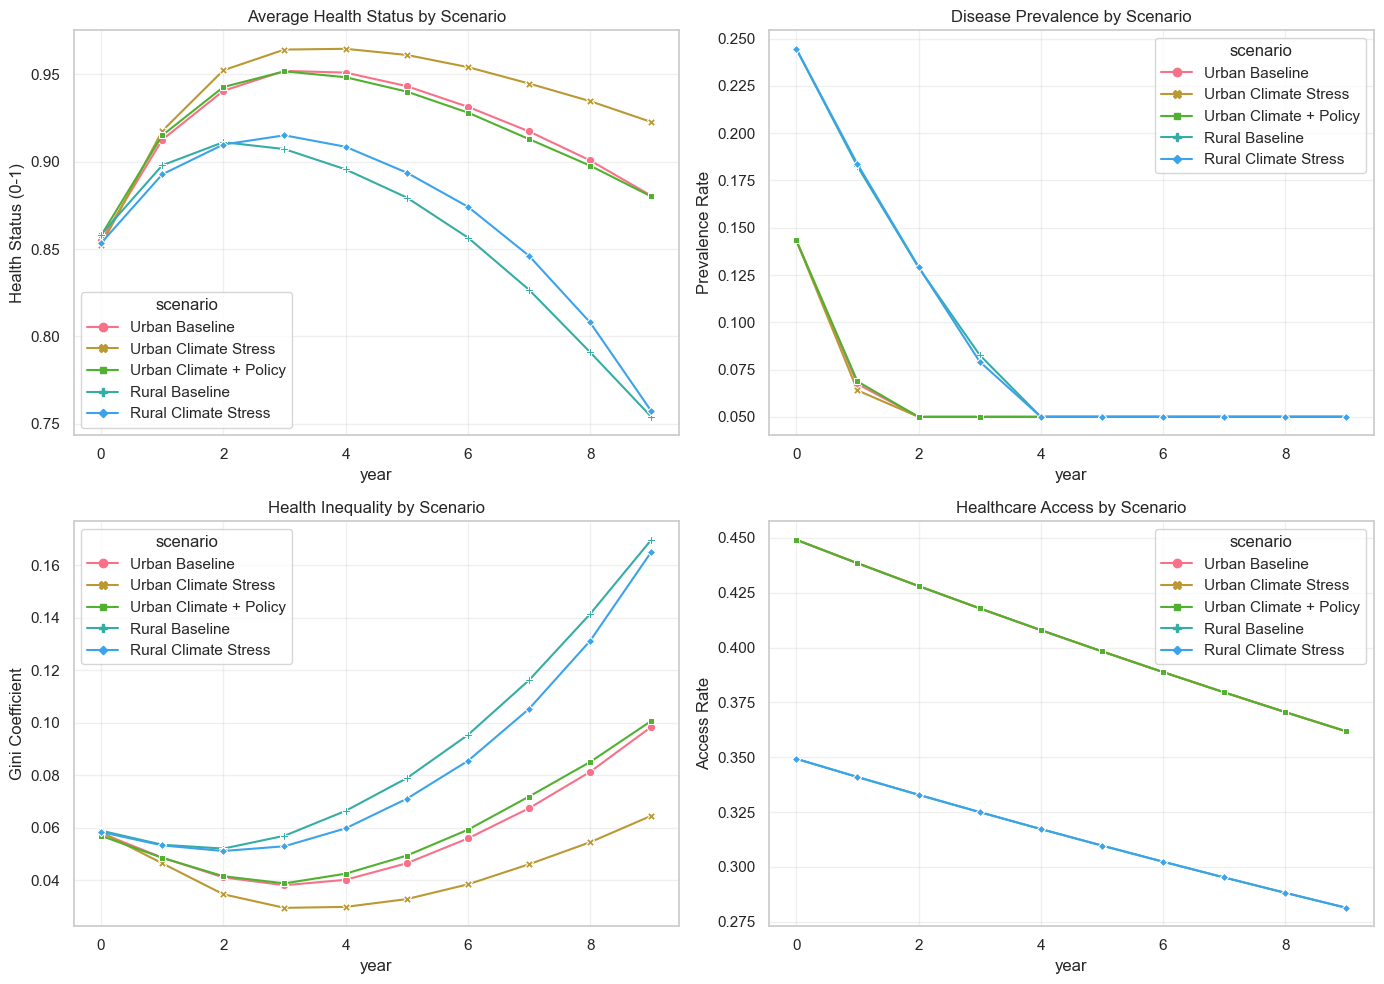


=== FINAL SCENARIO COMPARISON ===
                        Avg_Health  Disease_Prevalence  Health_Inequality
scenario                                                                 
Urban Climate Stress      0.922689                0.05           0.064619
Urban Baseline            0.880506                0.05           0.098507
Urban Climate + Policy    0.880079                0.05           0.100774
Rural Climate Stress      0.757324                0.05           0.165171
Rural Baseline            0.754045                0.05           0.169774


In [9]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skewnorm, beta

import seaborn as sns
sns.set_theme(style="whitegrid", palette="husl")

# -------------------------------
# ENHANCED SYSTEM DYNAMICS COMPONENT
# -------------------------------
class HealthSDModel:
    def __init__(self, region="urban"):
        """
        Enhanced system dynamics model with region-specific parameters
        """
        # Region-specific initial conditions
        self.region = region
        self.housing_quality = 0.65 if region == "urban" else 0.55
        self.air_quality_index = 0.75 if region == "urban" else 0.85
        self.disease_prevalence = 0.15 if region == "urban" else 0.25
        
        # Climate and environmental parameters
        self.climate_change_rate = 0.015  # annual deterioration rate
        self.extreme_weather_frequency = 0.07  # probability per year
        self.pollution_baseline = 0.3 if region == "urban" else 0.2
        
        # Healthcare system parameters
        self.healthcare_access = 0.45 if region == "urban" else 0.35
        self.public_health_budget = 1e6  # in local currency
        self.healthcare_efficiency = 0.7
        
        # Housing market parameters
        self.base_housing_deterioration = 0.008  # annual without maintenance
        self.housing_improvement_factor = 0.08  # effectiveness of investments
        self.housing_policy_effectiveness = 0.05
        
        # Track public investment separately
        self.current_public_investment = 0
        
        # Historical tracking with more metrics
        self.history = {
            'housing_quality': [self.housing_quality],
            'air_quality_index': [self.air_quality_index],
            'disease_prevalence': [self.disease_prevalence],
            'healthcare_access': [self.healthcare_access],
            'extreme_weather': [False],
            'public_investment': [self.current_public_investment]
        }

    def step(self, avg_investment=0, public_investment=0, extreme_weather=False):
        """
        Update SD model with enhanced realistic relationships
        """
        # Store the public investment for this step
        self.current_public_investment = public_investment
        
        # Climate impact with seasonal variation and extreme events
        month = len(self.history['housing_quality']) % 12
        seasonal_factor = 0.8 + 0.4 * np.sin(month * np.pi/6)
        climate_impact = (self.climate_change_rate * 
                        (1 - self.housing_quality) * 
                        seasonal_factor * 
                        (3 if extreme_weather else 1))
        
        # Air quality dynamics with multiple pollution sources
        industrial_pollution = 0.4 * (1 - self.housing_quality) if self.region == "urban" else 0.1
        traffic_pollution = 0.3 * (1 - self.housing_quality) if self.region == "urban" else 0.05
        self.air_quality_index = max(0.3, min(0.95,
            self.air_quality_index - 
            0.01 * industrial_pollution -
            0.008 * traffic_pollution -
            climate_impact * 0.04 +
            np.random.normal(0, 0.003)
        ))
        
        # Disease dynamics with healthcare system capacity constraints
        new_cases = (
            (1 - self.air_quality_index) * 
            (1 - self.healthcare_access) * 
            0.02 * (1.2 if extreme_weather else 1.0)
        )
        recovery_rate = min(
            0.03 * self.healthcare_access * self.healthcare_efficiency,
            self.disease_prevalence * 0.5  # Can't recover more than half the cases at once
        )
        self.disease_prevalence = max(0.05, min(0.8,
            self.disease_prevalence + new_cases - recovery_rate
        ))
        
        # Housing quality dynamics with multiple improvement sources
        maintenance_effect = (
            avg_investment * self.housing_improvement_factor +
            public_investment * self.housing_policy_effectiveness
        )
        deterioration = (
            self.base_housing_deterioration * 
            (1 + climate_impact) * 
            (1.5 if extreme_weather else 1.0)
        )
        self.housing_quality = max(0.2, min(0.9,
            self.housing_quality + maintenance_effect - deterioration
        ))
        
        # Healthcare system adaptation
        if self.disease_prevalence > 0.35:
            budget_allocation = min(0.03, self.public_health_budget/2e7)
            self.healthcare_access += budget_allocation
        self.healthcare_access = max(0.2, min(0.95, self.healthcare_access * 0.998))
        
        # Record history
        self.history['housing_quality'].append(self.housing_quality)
        self.history['air_quality_index'].append(self.air_quality_index)
        self.history['disease_prevalence'].append(self.disease_prevalence)
        self.history['healthcare_access'].append(self.healthcare_access)
        self.history['extreme_weather'].append(extreme_weather)
        self.history['public_investment'].append(self.current_public_investment)


# -------------------------------
# ENHANCED AGENT DEFINITIONS
# -------------------------------
class Household(Agent):
    def __init__(self, unique_id, model, income_level, education_level, location_type):
        """
        Enhanced household agent with realistic decision-making
        """
        super().__init__(unique_id, model)
        
        # Socioeconomic attributes
        self.income = max(0.1, income_level)  # Minimum income threshold
        self.education = education_level
        self.location = location_type  # "urban" or "rural"
        self.employment_status = np.random.choice(
            ["employed", "unemployed", "informal"],
            p=[0.7, 0.1, 0.2]
        )
        
        # Health attributes
        self.health_status = np.clip(0.7 + 0.3 * np.random.random(), 0.2, 1.0)
        self.medical_expenses = 0
        self.health_insurance = np.random.random() < (0.8 if income_level > 0.6 else 0.3)
        
        # Housing attributes
        self.housing_investment = 0
        self.housing_quality = model.sd_model.housing_quality * np.random.uniform(0.8, 1.2)
        
        # Behavioral parameters
        self.risk_perception = np.random.beta(2, 5)  # Initially low risk perception
        self.social_connectedness = np.random.beta(3, 3)
        
        # Family characteristics
        self.family_size = min(8, np.random.poisson(2.5) + 1)
        self.children = np.random.randint(0, min(4, self.family_size))
        self.elderly = np.random.random() < 0.2  # 20% chance has elderly member

    def step(self):
        """Enhanced decision-making process with multiple factors"""
        sd = self.model.sd_model
        env_risk = 1 - sd.air_quality_index
        
        # Update risk perception based on multiple factors
        neighbor_agents = [self.model.grid.get_cell_list_contents([n])[0] 
                         for n in self.model.grid.get_neighbors(self.pos, include_center=False)]
        neighbor_health_effect = 0.1 if any(a.health_status < 0.4 for a in neighbor_agents) else 0
        
        self.risk_perception = min(0.95,
            self.risk_perception * 0.8 +
            env_risk * 0.15 +
            (0.05 if self.education > 0.6 else 0) +
            neighbor_health_effect
        )
        
        # Economic decision making
        if self.employment_status == "employed":
            income_change = np.random.normal(0.01, 0.005)
        elif self.employment_status == "informal":
            income_change = np.random.normal(-0.005, 0.01)
        else:  # unemployed
            income_change = np.random.normal(-0.02, 0.005)
        self.income = max(0.1, self.income * (1 + income_change))
        
        # Housing investment decision
        investment_prob = (
            0.2 * min(1, self.income/0.5) +  # Income effect
            0.3 * self.risk_perception +     # Risk perception
            0.1 * self.education +           # Education effect
            0.1 * (1 if self.children > 0 else 0.5)  # Child protection
        )
        
        if np.random.random() < investment_prob:
            invest_amount = min(
                0.07 * self.income * (1 + self.education),
                self.income * 0.2  # Maximum 20% of income
            )
            self.housing_investment += invest_amount
            self.housing_quality += invest_amount * 0.5  # Diminishing returns
            self.income -= invest_amount
        
        # Health dynamics
        vulnerability = (
            0.3 * (1 - self.income) +
            0.2 * (1 - self.education) +
            0.1 * (1 if self.elderly else 0.5) +
            0.2 * (1 - (0.7 if self.health_insurance else 0.3)) +
            0.2 * (1 - self.housing_quality)
        )
        
        health_change = (
            -env_risk * vulnerability * 0.1 * (1 - sd.healthcare_access) +
            (0.03 * sd.healthcare_access * (1 if self.health_insurance else 0.7))
        )
        self.health_status = np.clip(self.health_status + health_change, 0.1, 1.0)
        
        # Economic impact of poor health
        if self.health_status < 0.5:
            productivity_loss = (0.6 - self.health_status) * 0.1
            self.income *= (1 - productivity_loss)
            if not self.health_insurance:
                self.medical_expenses += (0.7 - self.health_status) * 0.05

class PolicyActor(Agent):
    def __init__(self, unique_id, model, policy_type="healthcare"):
        super().__init__(unique_id, model)
        self.policy_type = policy_type
        self.budget = 5e6  # Substantial budget for interventions
        self.intervention_thresholds = {
            "health": 0.4,
            "housing": 0.35,
            "environment": 0.5
        }
        self.last_intervention = -12  # Initialize to prevent immediate intervention

    def step(self):
        """Enhanced policy intervention logic"""
        current_step = self.model.schedule.time
        if current_step - self.last_intervention < 12:  # Minimum 1 year between interventions
            return
            
        health_data = self.model.datacollector.get_model_vars_dataframe()
        if health_data.empty:
            return
            
        current_health = health_data['Avg_Health'].iloc[-1]
        disease_prevalence = health_data['Disease_Prevalence'].iloc[-1]
        housing_quality = health_data['Housing_Quality'].iloc[-1]
        
        # Determine intervention type based on worst performing metric
        if current_health < self.intervention_thresholds["health"]:
            self.implement_health_intervention()
            self.last_intervention = current_step
        elif housing_quality < self.intervention_thresholds["housing"]:
            self.implement_housing_intervention()
            self.last_intervention = current_step
        elif disease_prevalence > self.intervention_thresholds["environment"]:
            self.implement_environmental_intervention()
            self.last_intervention = current_step

    def implement_health_intervention(self):
        if self.budget >= 2e5:
            effectiveness = min(0.1, self.budget/5e6)
            self.model.sd_model.healthcare_access += effectiveness
            self.model.sd_model.healthcare_efficiency = min(
                0.9, 
                self.model.sd_model.healthcare_efficiency + 0.05
            )
            self.budget -= 2e5
            print(f"Health intervention implemented at step {self.model.schedule.time}")

    def implement_housing_intervention(self):
        if self.budget >= 3e5:
            effectiveness = min(0.15, self.budget/4e6)
            # Distribute investment across households
            avg_investment = effectiveness * 1e5 / len(self.model.schedule.agents)
            for agent in self.model.schedule.agents:
                if isinstance(agent, Household):
                    agent.housing_quality += avg_investment * 0.8
            self.budget -= 3e5
            print(f"Housing intervention implemented at step {self.model.schedule.time}")

    def implement_environmental_intervention(self):
        if self.budget >= 4e5:
            effectiveness = min(0.2, self.budget/3e6)
            self.model.sd_model.air_quality_index = min(
                0.95,
                self.model.sd_model.air_quality_index + effectiveness * 0.1
            )
            self.model.sd_model.pollution_baseline *= (1 - effectiveness * 0.3)
            self.budget -= 4e5
            print(f"Environmental intervention implemented at step {self.model.schedule.time}")

# -------------------------------
# ENHANCED HYBRID MODEL
# -------------------------------
class HybridModel(Model):
    def __init__(self, N_households=500, region="urban"):
        super().__init__()
        self.region = region
        self.sd_model = HealthSDModel(region=region)
        
        # Create social network structure
        self.G = nx.watts_strogatz_graph(N_households, 6, 0.1)
        self.grid = NetworkGrid(self.G)
        self.schedule = RandomActivation(self)
        self.time = 0  # Track months
        
        # Enhanced data collection - only collect from Household agents
        self.datacollector = DataCollector(
            model_reporters={
                "Avg_Health": self.calculate_avg_health,
                "Health_Inequality": self.calculate_health_inequality,
                "Housing_Quality": lambda m: m.sd_model.housing_quality,
                "Air_Quality_Index": lambda m: m.sd_model.air_quality_index,
                "Disease_Prevalence": lambda m: m.sd_model.disease_prevalence,
                "Healthcare_Access": lambda m: m.sd_model.healthcare_access,
                "Extreme_Weather": lambda m: m.sd_model.history['extreme_weather'][-1],
                "Public_Investment": lambda m: m.sd_model.history['public_investment'][-1]
            },
            agent_reporters={
                "Health": lambda a: a.health_status if isinstance(a, Household) else None,
                "Income": lambda a: a.income if isinstance(a, Household) else None,
                "Education": lambda a: a.education if isinstance(a, Household) else None,
                "Location": lambda a: a.location if isinstance(a, Household) else None,
                "Employment": lambda a: a.employment_status if isinstance(a, Household) else None,
                "Insurance": lambda a: a.health_insurance if isinstance(a, Household) else None,
                "Investment": lambda a: a.housing_investment if isinstance(a, Household) else None,
                "Medical_Expenses": lambda a: a.medical_expenses if isinstance(a, Household) else None,
                "Housing_Quality": lambda a: a.housing_quality if isinstance(a, Household) else None
            }
        )
        
        # Create realistic population distribution
        for i, node in enumerate(self.G.nodes()):
            # Income distribution with region-specific parameters
            if region == "urban":
                income = np.clip(skewnorm.rvs(4, loc=0.5, scale=0.3), 0.2, 1.5)
            else:
                income = np.clip(skewnorm.rvs(6, loc=0.4, scale=0.25), 0.1, 1.2)
            
            # Education correlated with income with safeguarded beta parameters
            a = max(0.1, 1 + income*3)  # Ensure a > 0
            b = max(0.1, 3 - income*2)  # Ensure b > 0
            education = np.clip(beta.rvs(a, b), 0.2, 0.95)
            
            agent = Household(i, self, income, education, region)
            self.grid.place_agent(agent, node)
            self.schedule.add(agent)
        
        # Add policy actor
        self.policy_actor = PolicyActor(N_households, self)
        self.schedule.add(self.policy_actor)
    
    def calculate_avg_health(self):
        """Calculate population average health"""
        return np.mean([a.health_status for a in self.schedule.agents 
                       if isinstance(a, Household)])
    
    def calculate_health_inequality(self):
        """Calculate health inequality using Gini coefficient"""
        health = [a.health_status for a in self.schedule.agents 
                 if isinstance(a, Household)]
        if len(health) == 0:
            return 0
        sorted_health = np.sort(health)
        n = len(sorted_health)
        cum_health = np.cumsum(sorted_health)
        return (n + 1 - 2 * np.sum(cum_health)/(cum_health[-1])) / n
    
    def step(self):
        """Execute one time step (month)"""
        self.time += 1
        
        # Determine extreme weather event (region-specific probability)
        extreme_weather = False
        if self.region == "urban":
            weather_prob = 0.06/12  # monthly probability
        else:
            weather_prob = 0.04/12
            
        if np.random.random() < weather_prob:
            extreme_weather = True
            print(f"Extreme weather event at step {self.time}")
        
        # Calculate average community investment
        avg_investment = np.mean([
            a.housing_investment for a in self.schedule.agents
            if isinstance(a, Household)
        ]) if any(isinstance(a, Household) for a in self.schedule.agents) else 0
        
        # Calculate public investment (policy interventions)
        public_investment = self.sd_model.history['public_investment'][-1] * 0.9  # decay
        
        # Update SD model
        self.sd_model.step(
            avg_investment=avg_investment,
            public_investment=public_investment,
            extreme_weather=extreme_weather
        )
        
        # Update all agents
        self.schedule.step()
        
        # Collect data
        self.datacollector.collect(self)

# -------------------------------
# SCENARIO ANALYSIS FRAMEWORK
# -------------------------------
def run_scenario(scenario_name, climate_change_rate, policy_level, region="urban", years=10):
    """
    Enhanced scenario runner with more parameters
    """
    months = years * 12
    model = HybridModel(N_households=500, region=region)
    
    # Scenario-specific adjustments
    model.sd_model.climate_change_rate = climate_change_rate
    model.policy_actor.budget = policy_level * 1e6
    
    results = []
    for _ in range(months):
        model.step()
        if _ % 12 == 0:  # Annual snapshot
            results.append(model.datacollector.get_model_vars_dataframe().iloc[-1])
    
    df = pd.DataFrame(results)
    df['scenario'] = scenario_name
    df['year'] = np.arange(years)
    return df

def analyze_scenarios(scenarios):
    """
    Run multiple scenarios and return comprehensive results
    """
    all_results = []
    for name, params in scenarios.items():
        print(f"Running scenario: {name}")
        scenario_results = run_scenario(
            scenario_name=name,
            climate_change_rate=params['climate_rate'],
            policy_level=params['policy_level'],
            region=params['region'],
            years=params['years']
        )
        all_results.append(scenario_results)
    
    combined_results = pd.concat(all_results)
    
    # Calculate summary statistics
    summary = combined_results.groupby(['scenario', 'year']).agg({
        'Avg_Health': ['mean', 'std'],
        'Disease_Prevalence': ['mean', 'std'],
        'Health_Inequality': ['mean'],
        'Healthcare_Access': ['mean']
    })
    
    return combined_results, summary

# -------------------------------
# POLICY SCENARIOS
# -------------------------------
scenarios = {
    "Urban Baseline": {
        'climate_rate': 0.015,
        'policy_level': 1,
        'region': "urban",
        'years': 10
    },
    "Urban Climate Stress": {
        'climate_rate': 0.025,
        'policy_level': 1,
        'region': "urban",
        'years': 10
    },
    "Urban Climate + Policy": {
        'climate_rate': 0.025,
        'policy_level': 3,
        'region': "urban",
        'years': 10
    },
    "Rural Baseline": {
        'climate_rate': 0.015,
        'policy_level': 1,
        'region': "rural",
        'years': 10
    },
    "Rural Climate Stress": {
        'climate_rate': 0.025,
        'policy_level': 1,
        'region': "rural",
        'years': 10
    }
}

# Execute scenarios
results_df, summary_stats = analyze_scenarios(scenarios)

# -------------------------------
# VISUALIZATION
# -------------------------------
def plot_scenario_comparison(results):
    """Enhanced visualization of scenario results"""
    plt.figure(figsize=(14, 10))
    
    # Health outcomes
    plt.subplot(2, 2, 1)
    sns.lineplot(
        data=results,
        x='year', y='Avg_Health',
        hue='scenario',
        style='scenario',
        markers=True,
        dashes=False
    )
    plt.title('Average Health Status by Scenario')
    plt.ylabel('Health Status (0-1)')
    plt.grid(True, alpha=0.3)
    
    # Disease prevalence
    plt.subplot(2, 2, 2)
    sns.lineplot(
        data=results,
        x='year', y='Disease_Prevalence',
        hue='scenario',
        style='scenario',
        markers=True,
        dashes=False
    )
    plt.title('Disease Prevalence by Scenario')
    plt.ylabel('Prevalence Rate')
    plt.grid(True, alpha=0.3)
    
    # Health inequality
    plt.subplot(2, 2, 3)
    sns.lineplot(
        data=results,
        x='year', y='Health_Inequality',
        hue='scenario',
        style='scenario',
        markers=True,
        dashes=False
    )
    plt.title('Health Inequality by Scenario')
    plt.ylabel('Gini Coefficient')
    plt.grid(True, alpha=0.3)
    
    # Healthcare access
    plt.subplot(2, 2, 4)
    sns.lineplot(
        data=results,
        x='year', y='Healthcare_Access',
        hue='scenario',
        style='scenario',
        markers=True,
        dashes=False
    )
    plt.title('Healthcare Access by Scenario')
    plt.ylabel('Access Rate')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Generate visualizations
plot_scenario_comparison(results_df)

# Print key statistics
print("\n=== FINAL SCENARIO COMPARISON ===")
final_results = results_df[results_df['year'] == results_df['year'].max()]
print(final_results.groupby('scenario')[
    ['Avg_Health', 'Disease_Prevalence', 'Health_Inequality']
].mean().sort_values('Avg_Health', ascending=False))